# **Project: Disease detection from Chest X-Ray**

### **Project Goal:**
Build a deep learning model that can classify chest X-ray images as either Normal or Pneumonia, helping demonstrate how AI can support medical diagnosis.

### **Dataset:**
Chest X-Ray Images (Pneumonia) – Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- 5,863 total images across training, test, and validation folders
- Two classes: NORMAL, PNEUMONIA


### **1. Problem Understanding**

**What are you actually solving?**

- Binary classification: Normal vs Pneumonia

- Input: Chest X-ray images

- Output: A probability or class label

**Key mindset shift:**

- This is decision support, not diagnosis

- False negatives (missing pneumonia) are often more dangerous than false positives



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt


/Users/naghamhabli/Desktop/the ai engineering/chestXray/venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:

train_images = keras.utils.image_dataset_from_directory('data/train')

val_images = keras.utils.image_dataset_from_directory('data/val')

test_images = keras.utils.image_dataset_from_directory('data/test')

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2025-12-29 13:44:37.105673: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


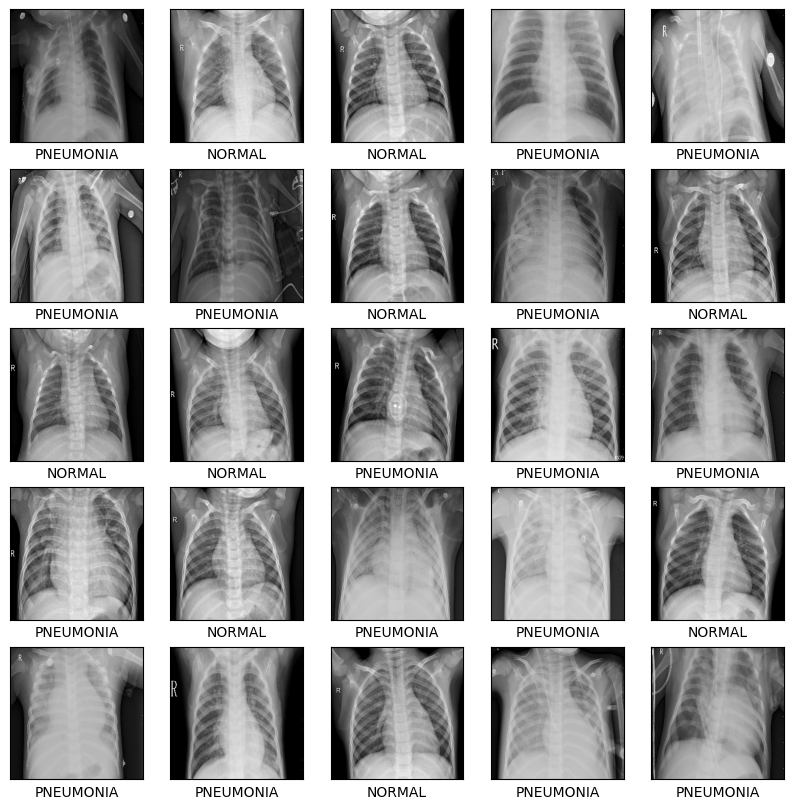

In [3]:
class_names = train_images.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_images.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(images[i].numpy().astype("uint8"))

        label = labels[i]
        if len(label.shape) > 0: 
            label_index = tf.argmax(label).numpy()
        else:
            label_index = label.numpy()

        plt.xlabel(class_names[label_index])

In [4]:
# understand the data structure 
for images, labels in train_images.take(1):
    print(images.shape) # (batch_size, height, width, channels)
    print(labels.shape) # (batch_size, ) 

# count the number of NORMAL and PNEUMONIA images in the training set
normal_count = 0
pneumonia_count = 0
for images, labels in train_images:
    normal_count += tf.reduce_sum(tf.cast(labels == 0, tf.int32)).numpy()
    pneumonia_count += tf.reduce_sum(tf.cast(labels == 1, tf.int32)).numpy()
print(f"Total NORMAL images in training set: {normal_count}")
print(f"Total PNEUMONIA images in training set: {pneumonia_count}")


(32, 256, 256, 3)
(32,)


2025-12-29 13:44:40.108158: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total NORMAL images in training set: 1341
Total PNEUMONIA images in training set: 3875


### Conclusion: Imbalanced dataset:

Based on the output, we can calculate the Class Distribution:
- Total Images: 1341 + 3875 = 5216
- Pneumonia : (3875 / 5216) * 100 ~ 74.3%
- Normal: (1341 / 5216) * 100 ~ 25.7%
We have nearly 3 times more Pneumonia cases than Normal cases. This is considered a **moderate to severe imbalance.**


**Effects on the model:**
If I were to train your model right now without addressing this, the following would likely happen:

- **The "Lazy" Model**: The model would achieve 74% accuracy by simply guessing "Pneumonia" every single time without even looking at the image pixels.

- **High False Positives:** The model will be biased toward finding disease. It might see a slight shadow in a healthy lung and immediately label it "Pneumonia" because it "expects" that class more often.

- **Misleading Accuracy:** You might feel proud of an 85% accuracy score, but if you check the Recall for the "Normal" class, it might be very low (meaning the model is failing to identify healthy people correctly).


**How to fix this issue:**
the easiest way to fix this during training is using **Class Weights**. This tells the loss function to penalize mistakes on "Normal" images more heavily than mistakes on "Pneumonia" images. We add this logic before model.fit

**But first, we have to resize the images, normalize and augment before building the model layers and fit**

In [14]:
IMAGE_SIZE = (224, 224)  # resize images to 224x224
BATCH_SIZE = 32  

train_images = keras.utils.image_dataset_from_directory(
    'data/train',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True
)

val_images = keras.utils.image_dataset_from_directory(
    'data/val',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

test_images = keras.utils.image_dataset_from_directory(
    'data/test',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


> **label_mode="binary"**

- Because this is Normal vs Pneumonia

- Outputs labels as 0/1

- Matches binary classification loss later

> **shuffle=False** for val/test

- Ensures consistent evaluation

- Prevents confusion matrix mismatches



In [15]:
# data augmentation to reduce overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [16]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,        # remove ImageNet classifier
    weights='imagenet',       # use pretrained weights
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # FREEZE it initially


In [17]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_images = train_images.map(preprocess)
val_images   = val_images.map(preprocess)
test_images  = test_images.map(preprocess)


In [18]:
model = tf.keras.Sequential([
    data_augmentation,          # keep your augmentation
    base_model,                 # pretrained backbone
    layers.GlobalAveragePooling2D(), # replaces Flatten (less overfitting)
    layers.BatchNormalization(), # stabilizes training

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')  # binary output
])


In [19]:
# class weights calculation for handling class imbalance
# the counts from the previous step
count_normal = 1341
count_pneumonia = 3875
total = count_normal + count_pneumonia

# Calculate weights: (Total / 2) / class_count
# This ensures that the sum of weights remains balanced relative to the total samples
weight_for_0 = (total / 2.0) / count_normal      # Normal
weight_for_1 = (total / 2.0) / count_pneumonia   # Pneumonia

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for NORMAL (0): {weight_for_0:.2f}")
print(f"Weight for PNEUMONIA (1): {weight_for_1:.2f}")

Weight for NORMAL (0): 1.94
Weight for PNEUMONIA (1): 0.67


In [20]:
base_model.trainable = True

# Optional: freeze lower layers
for layer in base_model.layers[:200]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name="recall")]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=15,
    class_weight=class_weight,
    callbacks=[early_stop]
)


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 247ms/step - accuracy: 0.6639 - auc: 0.7844 - loss: 0.6114 - recall: 0.6204 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.4796 - val_recall: 0.8750
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 236ms/step - accuracy: 0.7922 - auc: 0.9129 - loss: 0.4022 - recall: 0.7556 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.2961 - val_recall: 1.0000
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.8317 - auc: 0.9380 - loss: 0.3423 - recall: 0.8023 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.2013 - val_recall: 1.0000
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 242ms/step - accuracy: 0.8658 - auc: 0.9565 - loss: 0.2841 - recall: 0.8446 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1646 - val_recall: 1.0000
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 246ms/step - accuracy: 0.8763 - auc: 0.9596 - loss: 0.2687 - recall: 0.8604 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1431 - val_recall: 1.

### **Training Results Summary**

After correcting the preprocessing and learning rate, the EfficientNetB0-based model showed clear and stable learning behavior. Training accuracy and AUC increased steadily, reaching approximately 95% accuracy and 0.99 AUC, while training loss consistently decreased.

Validation performance also improved, with accuracy ranging from 87.5% to 100% and AUC reaching 1.00, indicating strong class separability. Validation loss decreased across epochs, suggesting good generalization, though results should be interpreted cautiously due to the small validation set size.

Overall, the model demonstrates effective transfer learning and high recall, making it suitable for pneumonia detection tasks where sensitivity is a priority. Final performance should be confirmed using the independent test set.



In [21]:
model.evaluate(test_images)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.8782 - auc: 0.9544 - loss: 0.2890 - recall: 0.9590


[0.2889598309993744,
 0.8782051205635071,
 0.9543502330780029,
 0.9589743614196777]

### **Test evaluation summary**
On the test set, the model achieved 88% accuracy, AUC of 0.954, and recall of 0.959. This indicates that the model generalizes well and is highly sensitive to pneumonia cases, making it suitable for medical screening tasks. The high AUC confirms strong class separability, while the slightly lower accuracy compared to validation is expected due to natural variability in unseen data.